# Hourly clustering over whole year 2024

In [1]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation
from cluster_statistics import plot_cluster_percentiles
from Hyperparameters_KMeans import optimize_kmeans


## Data Clustering

In [13]:


input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

#input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [14]:

key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)
#['tenant type', 'age', 'monthly income', 'education level', 'employment status']
# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 142]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'Building Type']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

Total rows: 1500
Unique house-id count: 1500
No duplicates found in house_id column.


In [15]:


# Drop rows where 'Building Type' is 'House'
category_df = extracted_df.copy()
category_df = category_df[category_df['Building Type'] != 'No Information']

category_df_tot = category_df.copy()

category_df_flat = category_df[category_df['Building Type'] != 'House']

category_df_house = category_df[category_df['Building Type'] != 'Flat']


category_df_tot = category_df_tot.drop(columns=['Building Type'])
category_df_tot = category_df_tot.drop(columns=['house-id'])

category_df_flat = category_df_flat.drop(columns=['Building Type'])
category_df_flat = category_df_flat.drop(columns=['house-id'])

category_df_house = category_df_house.drop(columns=['Building Type'])
category_df_house = category_df_house.drop(columns=['house-id'])

#print(category_df_tot.head(24))
#print(category_df_flat.head(12))
#print(category_df_house.head(12))




In [18]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

clusters_train = {}
train_data = {}

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for cat, categories in enumerate([category_df_tot, category_df_flat, category_df_house]):

    data_list = []

    for idx, file_path in enumerate(file_paths):
        df = pl.read_csv(file_path)
        
        if pattern.search(os.path.basename(file_path)).group(1) in categories['CH_id'].values:  
            if len(df) == n_timestamps:
                values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
                data_list.append(values_array)

    if data_list:
        data_3d = np.concatenate(data_list, axis=0)
        print(f"Shape of the 3D array: {data_3d.shape}")

    train_data[cat] = data_3d

    n_clusters = 1  # Number of clusters, you can adjust this
    max_iterations =100
    n_init = 1

    kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
    clusters_train[cat] = kmeans.fit_predict(train_data[cat])



Shape of the 3D array: (1277, 96, 1)
Shape of the 3D array: (801, 96, 1)
Shape of the 3D array: (476, 96, 1)


# Plotting the cluster average patterns

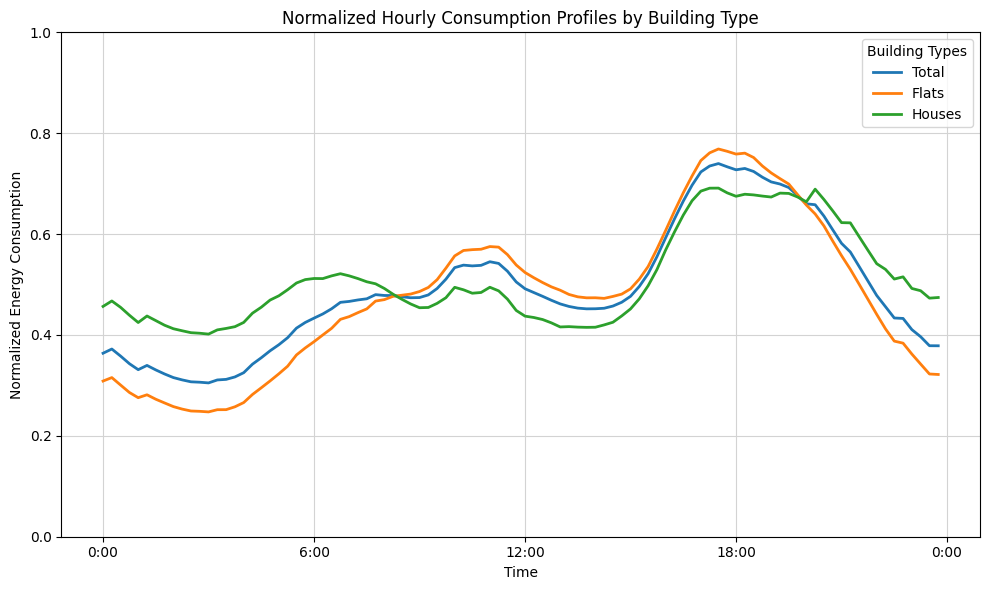

In [26]:
# Plot-Funktion, um alle Kategorien zusammen darzustellen
def plot_all_categories_together(train_data, clusters_train):
    labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
    legend_titles = ['Total', 'Flats', 'Houses']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    plt.figure(figsize=(10,6))
    
    for cat in range(len(train_data)):
        data = train_data[cat]
        if data.shape[0] == 0:
            continue
        
        # Mittlere Zeitreihe über alle Samples
        mean_time_series = np.mean(data, axis=0)
        plt.plot(range(1, 97), mean_time_series.ravel(),
                 label=legend_titles[cat],
                 linewidth=2,
                 color=colors[cat])
        
    plt.title('Normalized Hourly Consumption Profiles by Building Type')
    plt.xlabel('Time')
    plt.ylabel('Normalized Energy Consumption')
    plt.ylim(0, 1)
    plt.xticks(ticks=[1, 25, 49, 73, 97], labels=labels)
    plt.grid(True, color='lightgray')
    plt.legend(title = 'Building Types',loc='upper right', fontsize='medium')
    plt.tight_layout()
    
    plt.savefig("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/HourlyAveraged_AllCategories.png", bbox_inches='tight')
    plt.show()

# Aufruf des Plots
plot_all_categories_together(train_data, clusters_train)

## Actual energy consumption of each cluster

In [110]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")

result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering.csv")



In [111]:


# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = round(result_df["bruttolastgang_kwh_sum"].mean(),2)
overall_seasonal_avg = round(result_df['average_daily_consumption'].mean(),2)

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "avg_daily_consumption [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (2, 4)
┌──────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---      ┆ ---            ┆ ---                          ┆ ---                         │
│ str      ┆ u32            ┆ f64                          ┆ f64                         │
╞══════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1        ┆ 801            ┆ 2975.2                       ┆ 5.07                        │
│ Combined ┆ 801            ┆ 2975.2                       ┆ 5.07                        │
└──────────┴────────────────┴──────────────────────────────┴─────────────────────────────┘


### Plotting the clusters in separate plots

Cluster 1: PAR =' 1.61' 


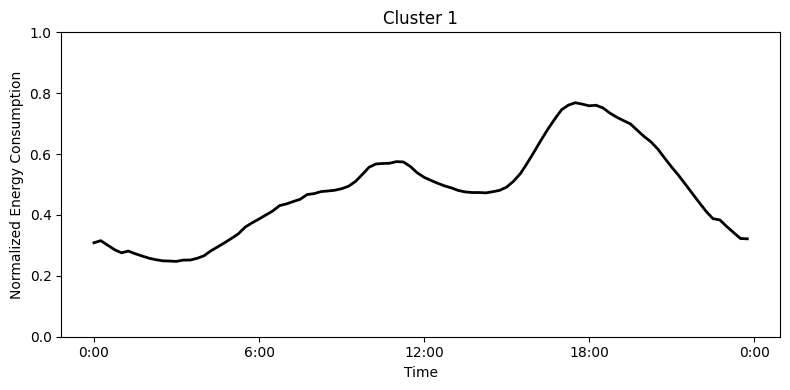

In [112]:
# Calculate and plot the average pattern for each cluster
save = 0 #if you want to save the plots

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['black','orange','red','green','lightgrey','pink','darkgrey','darkblue','blue','indianred','purple','magenta','pink','violet']

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)
    print(f"Cluster {cluster_idx+1}: PAR =' {PAR_max/PAR_average:.2f}' ")
    
    # Plot the mean time series
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1,97), mean_time_series.ravel()[:96], 
             label= f'Mean Time Series \n No. of Time Series: {len(cluster_indices)}',
               linewidth =2, color= colors[cluster_idx] )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


### Plotting Mean, Median and percentiles of the clusters

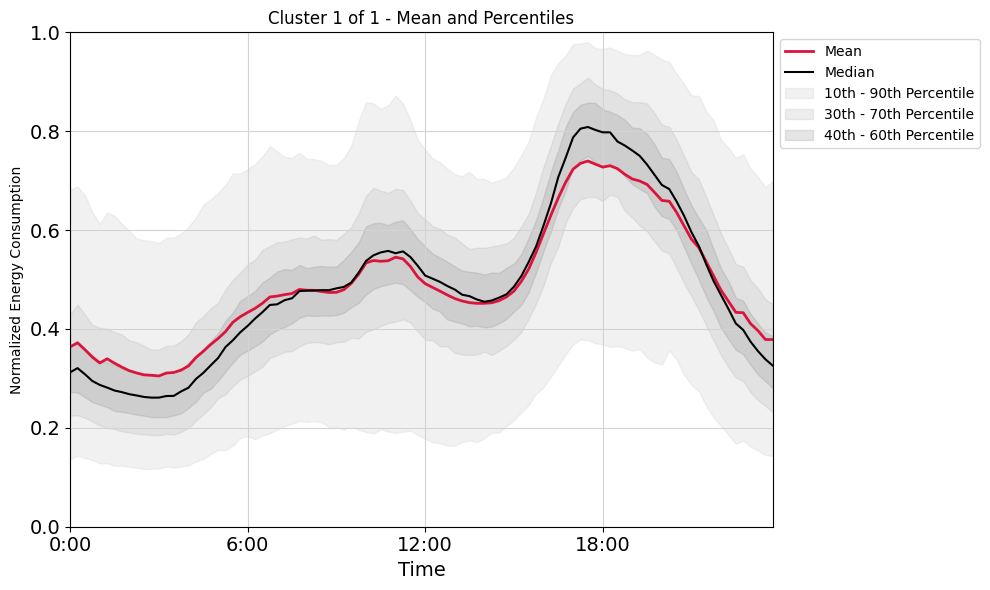

shape: (96, 2)
┌────────────────────────────┬────────────────────────────┐
│ lower_percentile_cluster_1 ┆ upper_percentile_cluster_1 │
│ ---                        ┆ ---                        │
│ f64                        ┆ f64                        │
╞════════════════════════════╪════════════════════════════╡
│ 0.136722                   ┆ 0.682405                   │
│ 0.143431                   ┆ 0.688273                   │
│ 0.139187                   ┆ 0.670235                   │
│ 0.13467                    ┆ 0.636566                   │
│ 0.128426                   ┆ 0.612402                   │
│ …                          ┆ …                          │
│ 0.174364                   ┆ 0.75331                    │
│ 0.161984                   ┆ 0.72419                    │
│ 0.154265                   ┆ 0.707689                   │
│ 0.145361                   ┆ 0.686329                   │
│ 0.142932                   ┆ 0.699312                   │
└────────────────────────

In [25]:
plot_cluster_percentiles(train_data[0], clusters_train[0], n_clusters)

#print(train_data, clusters_train, n_clusters)

Cluster 1: PAR = 1.61
Cluster 2: PAR = nan
Cluster 3: PAR = nan
Cluster 4: PAR = nan


/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/MLDA/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide

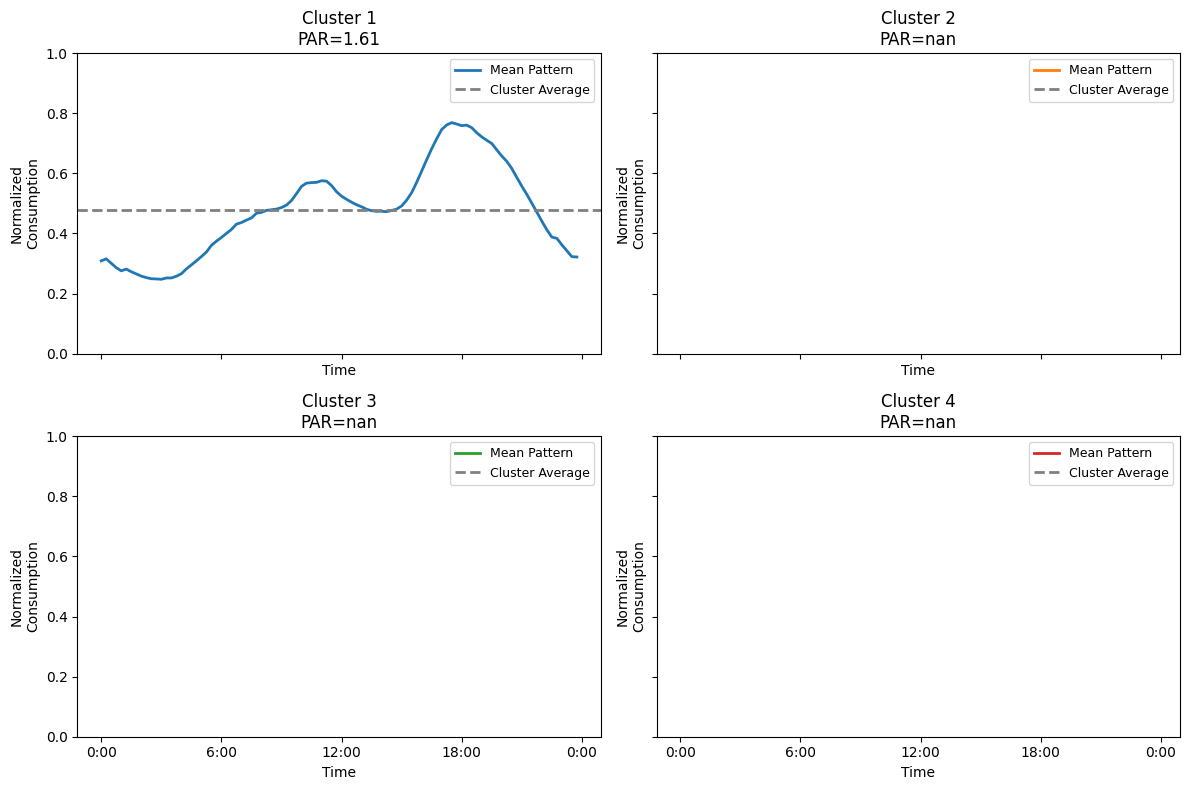

In [114]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

# Compute the mean time series and PAR for each cluster and store for subplot
mean_time_series_all = []
mean_lines = []

n_clusters_to_plot = 4
f, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
axs = axs.flatten()

for cluster_idx in range(n_clusters_to_plot):
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    

    mean_time_series = np.mean(cluster_data, axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)
    print(f"Cluster {cluster_idx+1}: PAR = {PAR_max/PAR_average:.2f}")

    # Individual plots (optional)
    
    # Subplot (2x2)
    ax = axs[cluster_idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96], 
                 label='Mean Pattern', linewidth=2, color=colors[cluster_idx])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cluster_idx+1}\nPAR={PAR_max/PAR_average:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized\nConsumption")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, 120, 24))
    ax.set_xticklabels(labels)
    ax.legend(fontsize=9)

plt.tight_layout()
    
plt.savefig(
"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/PAR_Kmeans.png",
bbox_inches='tight'
)
plt.show()